## Define Imports and Determine Device

In [20]:
#!/usr/bin/env python
# coding: utf-8

# ## Define Imports and Determine Device
import os, sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
os.sys.path.insert(0, "source")
from DiabetesData import DiabeticData
from Autoencoder import ConvAutoencoder
from ConvVarAutoencoder import ConvVAE
from DogCatData import DogCatData
%matplotlib inline

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
datatype="dogcat"
batch_size=16
epochs = 0
model_file = "models/ConvAE_dogcat_56.pth"
normalize=False
size=100

cuda


# read in data

In [22]:
if datatype == "diabetes":
    filename = "data/trainLabels_ad.csv"
    root_dir = "data/diabetes_resized"
    task = ([0],[4])
    # task = ([0,1,2], [3,4])
    # task = ([0,1,2], (3,4))
    classes = ["none", "proliferative"]
    train = pd.read_csv("data/diabetes_ad_train.csv")
    val = pd.read_csv("data/diabetes_ad_valid.csv")
    test = pd.read_csv("data/diabetes_ad_test.csv")

    data = {'train': DiabeticData(df = train, transform_key="train", root_dir=root_dir, task = task, normalize = normalize),
            'valid': DiabeticData(df = val, transform_key="valid", root_dir=root_dir, task = task, normalize = normalize),
            'test': DiabeticData(df = test, transform_key="test", root_dir=root_dir, task = task, normalize = normalize)
            }


elif datatype == "dogcat":
    filename = "data/dogcat_ad.csv"
    root_dir = "data/dogcat/train"
    classes = ['dog', 'cat']
    # task = ([0,1,2], (3,4))

    train = pd.read_csv("data/dogcat_ad_train.csv")
    val = pd.read_csv("data/dogcat_ad_valid.csv")
    test = pd.read_csv("data/dogcat_ad_test.csv")

    data = {'train': DogCatData(df = train, transform_key="train", root_dir=root_dir, normalize = normalize),
            'valid': DogCatData(df = val, transform_key="valid", root_dir=root_dir, normalize = normalize),
            'test': DogCatData(df = test, transform_key="test", root_dir=root_dir, normalize = normalize)
            }

dataloaders = {
        'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True),
        'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
} 


       Unnamed: 0       filename  label text_label
0           11301    dog.892.jpg      0        dog
1            8981   dog.6831.jpg      0        dog
2           10970   dog.8621.jpg      0        dog
3            8608   dog.6496.jpg      0        dog
4            7027   dog.5072.jpg      0        dog
...           ...            ...    ...        ...
11269        7981   dog.5931.jpg      0        dog
11270        9460   dog.7262.jpg      0        dog
11271        1604  dog.11440.jpg      0        dog
11272        8762   dog.6634.jpg      0        dog
11273        3741   dog.2114.jpg      0        dog

[11274 rows x 4 columns]
      Unnamed: 0       filename  label text_label
0          15337   cat.1300.jpg      1        cat
1          14916  cat.12171.jpg      1        cat
2          15181   cat.1241.jpg      1        cat
3          12769  cat.10239.jpg      1        cat
4          14544  cat.11837.jpg      1        cat
...          ...            ...    ...        ...
2123       1

In [23]:
model = ConvAutoencoder(device, datatype)
print(model)
if model_file != "":
    model.load_state_dict(torch.load(model_file))

model.fit(epochs, dataloaders["train"], dataloaders["valid"])


ConvAutoencoder(
  (encoder_layers): ModuleList(
    (0): Conv2d(3, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(1024, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder_layers): ModuleList(
    (0): ConvTranspose2d(4, 1024, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(1024, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
  (criterion): BCELoss()
)
in fit function


<Figure size 432x288 with 0 Axes>

/home/tntech.edu/kebrown46/miniconda3/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/tntech.edu/kebrown46/miniconda3/envs/xai/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


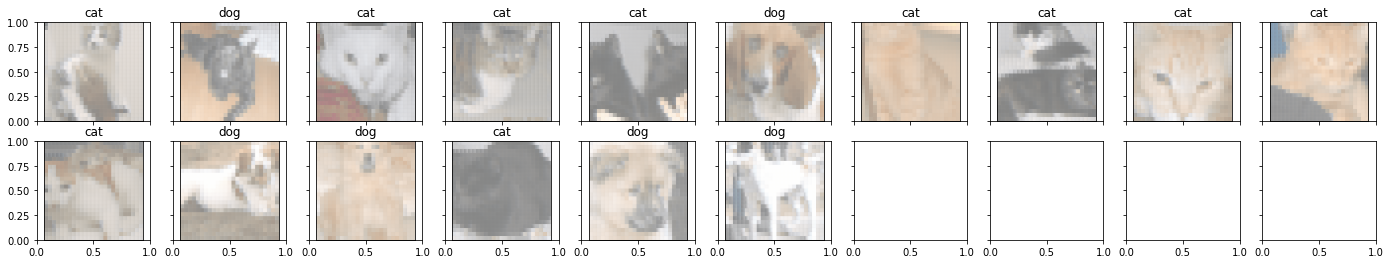

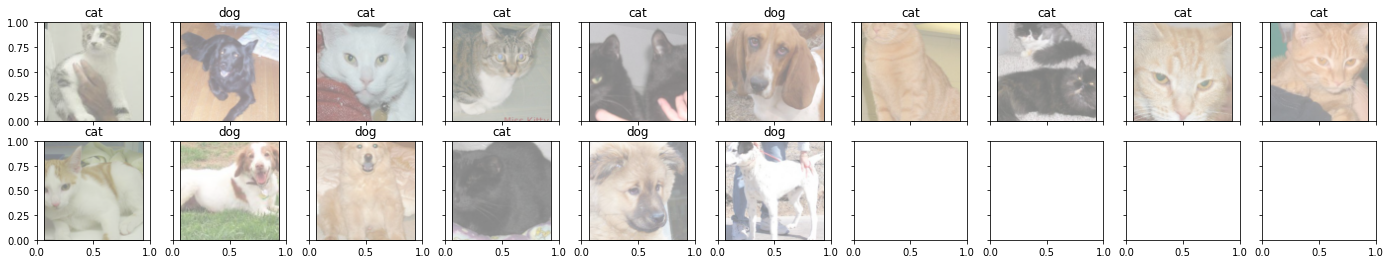

In [24]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))


# obtain one batch of test images
dataiter = iter(dataloaders["test"])
images, labels = dataiter.next()
images, labels = dataiter.next()

# get sample outputs
output = model(images.to(device))
# output = F.softmax(output)
# prep images for display
images = images.numpy()


# output is resized into a batch of iages
output = output.view(batch_size, 3, size, size)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))

# # input images on top row, reconstructions on bottom
# for images, row in zip([images, output], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])


# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


Now, we loop through the training set and calculate reconstruction loss 

In [25]:
dataloaders['valid'] = DataLoader(data['valid'], batch_size=1, shuffle=True)
dataloaders['test'] = DataLoader(data['test'], batch_size=1, shuffle=True)

results = []
results_cols = ["Image Label", "Reconstruction Loss"]
for x, y in dataloaders['valid']:
    X = x.to(device)
    output = model(X)
    output = output.cpu().detach().numpy()
    for i in range(y.shape[0]):
        ls = 0
        image = x[i].numpy()
        ouptut = output[i]
        label = y[i].numpy()
        ls = np.sum(np.square(image.ravel() - output.ravel()))
        # ls = model.criterion(output, image)
        results.append([label, ls])

results = pd.DataFrame(results, columns=results_cols)
results.to_csv("reconstruction_error.csv")


#find error threshold on validation set



#evaluate on testing data

     Image Label  Reconstruction Loss
0              0           133.357346
1              1           167.634369
2              1           168.514038
3              1            59.141228
4              1            82.483032
...          ...                  ...
2123           1           152.568604
2124           1            96.957535
2125           1           143.538208
2126           1           150.934982
2127           0            28.636333

[2128 rows x 2 columns]
     Image Label  Reconstruction Loss
0              0           133.357346
5              0            78.439308
15             0           153.786530
20             0           116.190697
21             0           244.668640
...          ...                  ...
2118           0           195.878784
2120           0           161.330902
2121           0            73.527885
2122           0           375.398315
2127           0            28.636333

[614 rows x 2 columns]
     Image Label  Reconstruction Loss
1

Text(0, 0.5, 'Frequency')

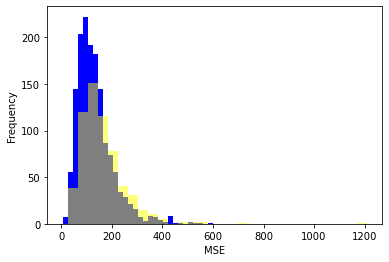

In [26]:
print(results)
label_1 = results[results["Image Label"] == 1]
label_0 = results[results["Image Label"] == 0]
print(label_0)
print(label_1)
avg_1 = np.mean(label_1['Reconstruction Loss'].values)
avg_0 = np.mean(label_0['Reconstruction Loss'].values)

print("Average Reconstruction Error (Prediction = 0)", avg_0)
print("Average Reconstruction Error (Prediction = 1)", avg_1)

plt.hist(label_1['Reconstruction Loss'].values, density=False, bins=30, color='blue')
plt.hist(label_0['Reconstruction Loss'].values, density=False, bins=30, alpha = 0.5,color='yellow')
plt.xlabel('MSE')
plt.ylabel('Frequency')


In [ ]:
threshold = 25
y_true = []
y_pred = []
for x, y in dataloaders['test']:
    X = x.to(device)
    output = model(X)
    output = output.cpu().detach().numpy()
    for i in range(y.shape[0]):
        ls = 0
        image = x[i].numpy()
        ouptut = output[i]
        label = y[i].numpy()
        ls = np.sum(np.square(image.ravel() - output.ravel()))
        print("Label: {0}\tReconstruction Loss: {1}\tPrediction: {2}".format(label,ls,int(ls >= threshold)))
        y_true.append(label)
        if ls >= threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)

print(y_true)
print(y_pred)

Label: 1	Reconstruction Loss: 206.08546447753906	Prediction: 1
Label: 0	Reconstruction Loss: 117.75352478027344	Prediction: 1
Label: 1	Reconstruction Loss: 64.12579345703125	Prediction: 1
Label: 1	Reconstruction Loss: 164.17282104492188	Prediction: 1
Label: 1	Reconstruction Loss: 157.69996643066406	Prediction: 1
Label: 0	Reconstruction Loss: 56.069091796875	Prediction: 1
Label: 0	Reconstruction Loss: 124.10652160644531	Prediction: 1
Label: 1	Reconstruction Loss: 130.5433807373047	Prediction: 1
Label: 0	Reconstruction Loss: 273.285400390625	Prediction: 1
Label: 1	Reconstruction Loss: 85.6131820678711	Prediction: 1
Label: 1	Reconstruction Loss: 178.14813232421875	Prediction: 1
Label: 1	Reconstruction Loss: 59.17242431640625	Prediction: 1
Label: 0	Reconstruction Loss: 121.2564468383789	Prediction: 1
Label: 0	Reconstruction Loss: 128.30116271972656	Prediction: 1
Label: 0	Reconstruction Loss: 224.27825927734375	Prediction: 1
Label: 1	Reconstruction Loss: 109.3064956665039	Prediction: 1
Labe

Label: 1	Reconstruction Loss: 128.96124267578125	Prediction: 1
Label: 0	Reconstruction Loss: 116.80647277832031	Prediction: 1
Label: 1	Reconstruction Loss: 113.34616088867188	Prediction: 1
Label: 1	Reconstruction Loss: 215.81394958496094	Prediction: 1
Label: 1	Reconstruction Loss: 148.1014862060547	Prediction: 1
Label: 1	Reconstruction Loss: 116.56275939941406	Prediction: 1
Label: 1	Reconstruction Loss: 52.82215118408203	Prediction: 1
Label: 1	Reconstruction Loss: 84.57013702392578	Prediction: 1
Label: 1	Reconstruction Loss: 115.3134765625	Prediction: 1
Label: 0	Reconstruction Loss: 194.87107849121094	Prediction: 1
Label: 1	Reconstruction Loss: 124.3086929321289	Prediction: 1
Label: 0	Reconstruction Loss: 234.29270935058594	Prediction: 1
Label: 1	Reconstruction Loss: 68.68756103515625	Prediction: 1
Label: 0	Reconstruction Loss: 110.12540435791016	Prediction: 1
Label: 0	Reconstruction Loss: 126.01431274414062	Prediction: 1
Label: 0	Reconstruction Loss: 217.47787475585938	Prediction: 1
L

Label: 0	Reconstruction Loss: 159.05258178710938	Prediction: 1
Label: 0	Reconstruction Loss: 114.814208984375	Prediction: 1
Label: 1	Reconstruction Loss: 68.4066390991211	Prediction: 1
Label: 1	Reconstruction Loss: 106.88906860351562	Prediction: 1
Label: 0	Reconstruction Loss: 230.8121337890625	Prediction: 1
Label: 1	Reconstruction Loss: 80.84717559814453	Prediction: 1
Label: 1	Reconstruction Loss: 62.37798309326172	Prediction: 1
Label: 0	Reconstruction Loss: 235.53529357910156	Prediction: 1
Label: 1	Reconstruction Loss: 42.48188781738281	Prediction: 1
Label: 1	Reconstruction Loss: 311.0656433105469	Prediction: 1
Label: 1	Reconstruction Loss: 143.80625915527344	Prediction: 1
Label: 1	Reconstruction Loss: 53.289398193359375	Prediction: 1
Label: 1	Reconstruction Loss: 66.8504867553711	Prediction: 1
Label: 1	Reconstruction Loss: 90.85952758789062	Prediction: 1
Label: 0	Reconstruction Loss: 99.60652160644531	Prediction: 1
Label: 1	Reconstruction Loss: 121.58003234863281	Prediction: 1
Label

Label: 1	Reconstruction Loss: 79.18214416503906	Prediction: 1
Label: 1	Reconstruction Loss: 158.60809326171875	Prediction: 1
Label: 1	Reconstruction Loss: 67.75299072265625	Prediction: 1
Label: 0	Reconstruction Loss: 134.65684509277344	Prediction: 1
Label: 1	Reconstruction Loss: 145.875732421875	Prediction: 1
Label: 1	Reconstruction Loss: 59.12480163574219	Prediction: 1
Label: 0	Reconstruction Loss: 270.3697814941406	Prediction: 1
Label: 1	Reconstruction Loss: 222.4832763671875	Prediction: 1
Label: 1	Reconstruction Loss: 156.87628173828125	Prediction: 1
Label: 1	Reconstruction Loss: 215.30545043945312	Prediction: 1
Label: 0	Reconstruction Loss: 131.0114288330078	Prediction: 1
Label: 1	Reconstruction Loss: 165.39939880371094	Prediction: 1
Label: 1	Reconstruction Loss: 157.12857055664062	Prediction: 1
Label: 0	Reconstruction Loss: 129.8065643310547	Prediction: 1
Label: 1	Reconstruction Loss: 79.62284088134766	Prediction: 1
Label: 1	Reconstruction Loss: 153.69996643066406	Prediction: 1
La

Label: 1	Reconstruction Loss: 135.78927612304688	Prediction: 1
Label: 0	Reconstruction Loss: 97.41464233398438	Prediction: 1
Label: 1	Reconstruction Loss: 241.52745056152344	Prediction: 1
Label: 1	Reconstruction Loss: 212.1024627685547	Prediction: 1
Label: 0	Reconstruction Loss: 105.18531799316406	Prediction: 1
Label: 1	Reconstruction Loss: 184.75042724609375	Prediction: 1
Label: 1	Reconstruction Loss: 245.36026000976562	Prediction: 1
Label: 0	Reconstruction Loss: 193.48678588867188	Prediction: 1
Label: 1	Reconstruction Loss: 334.03717041015625	Prediction: 1
Label: 1	Reconstruction Loss: 82.16921997070312	Prediction: 1
Label: 0	Reconstruction Loss: 135.0120391845703	Prediction: 1
Label: 1	Reconstruction Loss: 206.5514373779297	Prediction: 1
Label: 1	Reconstruction Loss: 285.07171630859375	Prediction: 1
Label: 0	Reconstruction Loss: 131.01220703125	Prediction: 1
Label: 1	Reconstruction Loss: 253.6649627685547	Prediction: 1
Label: 1	Reconstruction Loss: 84.84245300292969	Prediction: 1
La

Label: 1	Reconstruction Loss: 62.784881591796875	Prediction: 1
Label: 1	Reconstruction Loss: 48.891014099121094	Prediction: 1
Label: 0	Reconstruction Loss: 161.2811279296875	Prediction: 1
Label: 1	Reconstruction Loss: 115.32295227050781	Prediction: 1
Label: 1	Reconstruction Loss: 143.9890594482422	Prediction: 1
Label: 0	Reconstruction Loss: 344.49298095703125	Prediction: 1
Label: 1	Reconstruction Loss: 67.75785827636719	Prediction: 1
Label: 0	Reconstruction Loss: 142.26318359375	Prediction: 1
Label: 1	Reconstruction Loss: 165.8075408935547	Prediction: 1
Label: 1	Reconstruction Loss: 142.58621215820312	Prediction: 1
Label: 1	Reconstruction Loss: 98.9643783569336	Prediction: 1
Label: 1	Reconstruction Loss: 149.27743530273438	Prediction: 1
Label: 1	Reconstruction Loss: 150.2690887451172	Prediction: 1
Label: 0	Reconstruction Loss: 119.08419799804688	Prediction: 1
Label: 0	Reconstruction Loss: 127.1502914428711	Prediction: 1
Label: 1	Reconstruction Loss: 95.58818817138672	Prediction: 1
Labe

Label: 1	Reconstruction Loss: 134.24769592285156	Prediction: 1
Label: 1	Reconstruction Loss: 198.2545166015625	Prediction: 1
Label: 1	Reconstruction Loss: 120.28131103515625	Prediction: 1
Label: 1	Reconstruction Loss: 107.3096923828125	Prediction: 1
Label: 0	Reconstruction Loss: 100.34291076660156	Prediction: 1
Label: 1	Reconstruction Loss: 81.3373794555664	Prediction: 1
Label: 0	Reconstruction Loss: 124.07976531982422	Prediction: 1
Label: 1	Reconstruction Loss: 81.845947265625	Prediction: 1
Label: 1	Reconstruction Loss: 115.24671936035156	Prediction: 1
Label: 1	Reconstruction Loss: 335.69256591796875	Prediction: 1
Label: 1	Reconstruction Loss: 98.70482635498047	Prediction: 1
Label: 1	Reconstruction Loss: 54.319725036621094	Prediction: 1
Label: 1	Reconstruction Loss: 89.26791381835938	Prediction: 1
Label: 1	Reconstruction Loss: 116.96025085449219	Prediction: 1
Label: 0	Reconstruction Loss: 199.6990966796875	Prediction: 1
Label: 1	Reconstruction Loss: 199.80545043945312	Prediction: 1
La

Label: 1	Reconstruction Loss: 144.09153747558594	Prediction: 1
Label: 1	Reconstruction Loss: 127.52713012695312	Prediction: 1
Label: 0	Reconstruction Loss: 184.39666748046875	Prediction: 1
Label: 1	Reconstruction Loss: 78.65375518798828	Prediction: 1
Label: 1	Reconstruction Loss: 112.23757934570312	Prediction: 1
Label: 1	Reconstruction Loss: 64.83119201660156	Prediction: 1
Label: 0	Reconstruction Loss: 100.60235595703125	Prediction: 1
Label: 0	Reconstruction Loss: 118.05827331542969	Prediction: 1
Label: 0	Reconstruction Loss: 135.21755981445312	Prediction: 1
Label: 1	Reconstruction Loss: 131.4200897216797	Prediction: 1
Label: 0	Reconstruction Loss: 90.29275512695312	Prediction: 1
Label: 1	Reconstruction Loss: 33.42369842529297	Prediction: 1
Label: 0	Reconstruction Loss: 135.94676208496094	Prediction: 1
Label: 1	Reconstruction Loss: 449.8673095703125	Prediction: 1
Label: 1	Reconstruction Loss: 144.29385375976562	Prediction: 1
Label: 1	Reconstruction Loss: 149.4902801513672	Prediction: 1

Label: 1	Reconstruction Loss: 148.78518676757812	Prediction: 1
Label: 1	Reconstruction Loss: 71.63919830322266	Prediction: 1
Label: 0	Reconstruction Loss: 193.9487762451172	Prediction: 1
Label: 1	Reconstruction Loss: 188.71051025390625	Prediction: 1
Label: 0	Reconstruction Loss: 72.1844711303711	Prediction: 1
Label: 1	Reconstruction Loss: 102.71654510498047	Prediction: 1
Label: 1	Reconstruction Loss: 50.4234504699707	Prediction: 1
Label: 1	Reconstruction Loss: 131.5681610107422	Prediction: 1
Label: 1	Reconstruction Loss: 117.59949493408203	Prediction: 1
Label: 0	Reconstruction Loss: 171.1691131591797	Prediction: 1
Label: 1	Reconstruction Loss: 104.26756286621094	Prediction: 1
Label: 0	Reconstruction Loss: 59.889827728271484	Prediction: 1
Label: 1	Reconstruction Loss: 79.13248443603516	Prediction: 1
Label: 0	Reconstruction Loss: 137.60153198242188	Prediction: 1
Label: 0	Reconstruction Loss: 305.1241455078125	Prediction: 1
Label: 1	Reconstruction Loss: 114.51264953613281	Prediction: 1
La

Label: 0	Reconstruction Loss: 77.74447631835938	Prediction: 1
Label: 1	Reconstruction Loss: 179.22067260742188	Prediction: 1
Label: 1	Reconstruction Loss: 114.41667175292969	Prediction: 1
Label: 1	Reconstruction Loss: 129.71261596679688	Prediction: 1
Label: 1	Reconstruction Loss: 155.36807250976562	Prediction: 1
Label: 0	Reconstruction Loss: 234.3747100830078	Prediction: 1
Label: 1	Reconstruction Loss: 121.80673217773438	Prediction: 1
Label: 1	Reconstruction Loss: 145.65164184570312	Prediction: 1
Label: 1	Reconstruction Loss: 38.069305419921875	Prediction: 1
Label: 1	Reconstruction Loss: 127.96172332763672	Prediction: 1
Label: 1	Reconstruction Loss: 126.79178619384766	Prediction: 1
Label: 0	Reconstruction Loss: 104.9021987915039	Prediction: 1
Label: 1	Reconstruction Loss: 76.30642700195312	Prediction: 1
Label: 1	Reconstruction Loss: 157.86895751953125	Prediction: 1
Label: 1	Reconstruction Loss: 120.23478698730469	Prediction: 1
Label: 0	Reconstruction Loss: 313.88116455078125	Prediction

Label: 1	Reconstruction Loss: 60.15361022949219	Prediction: 1
Label: 0	Reconstruction Loss: 172.71957397460938	Prediction: 1
Label: 1	Reconstruction Loss: 133.79312133789062	Prediction: 1
Label: 1	Reconstruction Loss: 154.28341674804688	Prediction: 1
Label: 1	Reconstruction Loss: 119.63517761230469	Prediction: 1
Label: 0	Reconstruction Loss: 105.53173828125	Prediction: 1
Label: 0	Reconstruction Loss: 259.46197509765625	Prediction: 1
Label: 0	Reconstruction Loss: 208.04214477539062	Prediction: 1
Label: 1	Reconstruction Loss: 102.58283996582031	Prediction: 1
Label: 1	Reconstruction Loss: 80.128662109375	Prediction: 1
Label: 1	Reconstruction Loss: 75.89971160888672	Prediction: 1
Label: 1	Reconstruction Loss: 95.9382553100586	Prediction: 1
Label: 1	Reconstruction Loss: 181.1811981201172	Prediction: 1
Label: 1	Reconstruction Loss: 221.41360473632812	Prediction: 1
Label: 0	Reconstruction Loss: 134.19041442871094	Prediction: 1
Label: 1	Reconstruction Loss: 23.410844802856445	Prediction: 0
Lab

Label: 0	Reconstruction Loss: 189.8707733154297	Prediction: 1
Label: 1	Reconstruction Loss: 168.9512481689453	Prediction: 1
Label: 1	Reconstruction Loss: 82.85147857666016	Prediction: 1
Label: 1	Reconstruction Loss: 128.30172729492188	Prediction: 1
Label: 1	Reconstruction Loss: 79.02506256103516	Prediction: 1
Label: 0	Reconstruction Loss: 114.90206146240234	Prediction: 1
Label: 0	Reconstruction Loss: 73.40925598144531	Prediction: 1
Label: 1	Reconstruction Loss: 56.31222152709961	Prediction: 1
Label: 0	Reconstruction Loss: 54.32788848876953	Prediction: 1
Label: 1	Reconstruction Loss: 116.70259094238281	Prediction: 1
Label: 0	Reconstruction Loss: 396.2180480957031	Prediction: 1
Label: 0	Reconstruction Loss: 137.26742553710938	Prediction: 1
Label: 1	Reconstruction Loss: 116.9483871459961	Prediction: 1
Label: 0	Reconstruction Loss: 54.09981155395508	Prediction: 1
Label: 0	Reconstruction Loss: 331.6985168457031	Prediction: 1
Label: 1	Reconstruction Loss: 123.86736297607422	Prediction: 1
Lab

Label: 1	Reconstruction Loss: 188.88478088378906	Prediction: 1
Label: 1	Reconstruction Loss: 143.69113159179688	Prediction: 1
Label: 1	Reconstruction Loss: 115.73371887207031	Prediction: 1
Label: 0	Reconstruction Loss: 108.51221466064453	Prediction: 1
Label: 0	Reconstruction Loss: 97.13211822509766	Prediction: 1
Label: 1	Reconstruction Loss: 55.975772857666016	Prediction: 1
Label: 1	Reconstruction Loss: 55.92852020263672	Prediction: 1
Label: 1	Reconstruction Loss: 106.07762145996094	Prediction: 1
Label: 0	Reconstruction Loss: 54.66797637939453	Prediction: 1
Label: 1	Reconstruction Loss: 136.88233947753906	Prediction: 1
Label: 0	Reconstruction Loss: 166.47152709960938	Prediction: 1
Label: 0	Reconstruction Loss: 166.0025634765625	Prediction: 1
Label: 1	Reconstruction Loss: 100.85682678222656	Prediction: 1
Label: 1	Reconstruction Loss: 57.723960876464844	Prediction: 1
Label: 0	Reconstruction Loss: 111.1405029296875	Prediction: 1
Label: 0	Reconstruction Loss: 301.276123046875	Prediction: 1

Label: 1	Reconstruction Loss: 141.59580993652344	Prediction: 1
Label: 0	Reconstruction Loss: 104.51705169677734	Prediction: 1
Label: 1	Reconstruction Loss: 166.7943572998047	Prediction: 1
Label: 1	Reconstruction Loss: 231.1148223876953	Prediction: 1
Label: 1	Reconstruction Loss: 71.7848892211914	Prediction: 1
Label: 1	Reconstruction Loss: 92.49232482910156	Prediction: 1
Label: 1	Reconstruction Loss: 91.81893157958984	Prediction: 1
Label: 1	Reconstruction Loss: 149.22332763671875	Prediction: 1
Label: 0	Reconstruction Loss: 236.89761352539062	Prediction: 1
Label: 0	Reconstruction Loss: 55.07395935058594	Prediction: 1
Label: 1	Reconstruction Loss: 115.5865478515625	Prediction: 1
Label: 1	Reconstruction Loss: 81.53916931152344	Prediction: 1
Label: 0	Reconstruction Loss: 138.82077026367188	Prediction: 1
Label: 1	Reconstruction Loss: 126.71929931640625	Prediction: 1
Label: 0	Reconstruction Loss: 201.48800659179688	Prediction: 1
Label: 0	Reconstruction Loss: 106.00360107421875	Prediction: 1
L

In [33]:
accuracy = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print("Accuracy: ", accuracy)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-Score: ", f1)
print("Confusion Matrix: ", cm)

Accuracy:  0.6033834586466166
Precision:  0.6877094972067039
Recall:  0.8120052770448549
F1-Score:  0.7447065940713855
Confusion Matrix:  [[  53  559]
 [ 285 1231]]
